In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# PREFERENCE_DATA_PATH = "../data/preference/test_gemma.jsonl"
# PREFERENCE_DATA_PATH = "../../scratch/preference_data/gemma_preferences_social_reasoning.jsonl"
PREFERENCE_DATA_PATH = "../../scratch/preference_data/gemma_preferences_gender_align.jsonl"
# PREFERENCE_DATA_PATH = "../../scratch/preference_data/gemma_preferences_hh_golden.jsonl"
# PREFERENCE_DATA_PATH = "../data/preference/gemma_preferences_gender_align.jsonl"
# PREFERENCE_DATA_PATH = "../data/preference/gemma_preferences_social_reasoning.jsonl"
# PREFERENCE_DATA_PATH= "../data/preference/gemma_preferences_hh_golden_0_10000.jsonl"

def preprocess_preferences(df):
    df["pref_idx"] = df.groupby(["chosen", "rejected"]).ngroup()
    df = df.sort_values(by="pref_idx").reset_index(drop=True)
    df = df[["pref_idx"] + [col for col in df.columns if col != "pref_idx"]]
    # lower answer
    df["answer"] = df["answer"].str.lower()
    df["persona_idx"] = df["sex"] + "_" + df["age"] + "_" + df["nationality"] + "_" + df["social_class"]
    df["is_correct"] = df["answer"] == df["gt_answer"]

    return df

df = pd.read_json(PREFERENCE_DATA_PATH, lines=True)
df = preprocess_preferences(df)

In [3]:
# remove duplicates from df
df = df.drop_duplicates(subset=["pref_idx", "chosen", "rejected", "persona"])

In [4]:
df

,pref_idx,chosen,rejected,prompt,prompt_gen,gt_answer,persona,sex,age,nationality,social_class,raw_output,answer,persona_idx,is_correct
0,0,"""Congressman"" is a commonly used term to refer...","I don't know why they are called congressmen, ...","Why do we call them ""congressmen""? Isn't that ...",<bos><start_of_turn>user\nYou are a human eval...,b,The persona is a concerned and caring Swedish ...,male,40s,Swedish,lower,"Okay, here's my evaluation as a concerned Swed...",b,male_40s_Swedish_lower,True
1,0,"""Congressman"" is a commonly used term to refer...","I don't know why they are called congressmen, ...","Why do we call them ""congressmen""? Isn't that ...",<bos><start_of_turn>user\nYou are a human eval...,b,"A 35-year-old Italian man named Alessandro, wh...",male,adult,Italian,middle,"As Alessandro, a history enthusiast and tour g...",b,male_adult_Italian_middle,True
2,0,"""Congressman"" is a commonly used term to refer...","I don't know why they are called congressmen, ...","Why do we call them ""congressmen""? Isn't that ...",<bos><start_of_turn>user\nYou are a human eval...,b,"Meet Themba, a 10-year-old South African boy f...",male,child,South African,upper,"<Ans>B</Ans>\n\nHere's my reasoning, from Them...",b,male_child_South African_upper,True
3,0,"""Congressman"" is a commonly used term to refer...","I don't know why they are called congressmen, ...","Why do we call them ""congressmen""? Isn't that ...",<bos><start_of_turn>user\nYou are a human eval...,b,A young Japanese girl who loves Disney charact...,female,young child,Japanese,lower middle class,"Okay, here's my evaluation from the perspectiv...",b,female_young child_Japanese_lower middle class,True
4,0,"""Congressman"" is a commonly used term to refer...","I don't know why they are called congressmen, ...","Why do we call them ""congressmen""? Isn't that ...",<bos><start_of_turn>user\nYou are a human eval...,b,A young Egyptian girl who is a current student...,female,child,Egyptian,middle,"Okay, here's my evaluation as a young Egyptian...",b,female_child_Egyptian_middle,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167235,8361,Zoning ordinances often fail to address the di...,I understand your concern about how zoning ord...,Do zoning ordinances really not reflect women'...,<bos><start_of_turn>user\nYou are a human eval...,a,A middle-class Vietnamese elderly female who i...,female,elderly,Vietnamese,middle,"Okay, here's my evaluation as a middle-class V...",a,female_elderly_Vietnamese_middle,True
167236,8361,Zoning ordinances often fail to address the di...,I understand your concern about how zoning ord...,Do zoning ordinances really not reflect women'...,<bos><start_of_turn>user\nYou are a human eval...,a,"An empathetic young adult male from Vietnam, w...",male,young adult,Vietnamese,middle,"<Ans>B</Ans>\n\nHere's my reasoning, viewed th...",b,male_young adult_Vietnamese_middle,False
167237,8361,Zoning ordinances often fail to address the di...,I understand your concern about how zoning ord...,Do zoning ordinances really not reflect women'...,<bos><start_of_turn>user\nYou are a human eval...,a,A young child who loves Disney characters and ...,male,young,Indian,lower,"Okay, this is a tricky one! I'm a kid who love...",b,male_young_Indian_lower,False
167238,8361,Zoning ordinances often fail to address the di...,I understand your concern about how zoning ord...,Do zoning ordinances really not reflect women'...,<bos><start_of_turn>user\nYou are a human eval...,a,"The 19-year-old Chilean male, Carlos, is the t...",male,teenager,Chilean,lower,"<Ans>A</Ans>\n\n**Reasoning:**\n\nAs Carlos, I...",a,male_teenager_Chilean_lower,True


## Clean Metrics

### Util fn

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def get_per_persona_stats(df):

    accuracy_by_persona = df.groupby('persona_idx')['is_correct'].mean()

    option_bias_a = df.groupby('persona_idx')['answer'].apply(lambda x: (x == 'a').mean())
    option_bias_b = df.groupby('persona_idx')['answer'].apply(lambda x: (x == 'b').mean())
    option_bias_c = df.groupby('persona_idx')['answer'].apply(lambda x: (x == 'c').mean())

    majority_answers = (
    df.groupby("pref_idx")["answer"]
      .apply(lambda x: x.value_counts().idxmax())
      .reset_index(name="majority_answer")
    )

    df_merged = pd.merge(df, majority_answers, on="pref_idx", how="left")

    df_merged["disagree_with_majority"] = df_merged["answer"] != df_merged["majority_answer"]
    df_merged["agree_with_majority"] = df_merged["answer"] == df_merged["majority_answer"]

    disagree_with_majority = df_merged.groupby('persona_idx')['disagree_with_majority'].mean()
    agree_with_majority = df_merged.groupby('persona_idx')['agree_with_majority'].mean()

    
    # put everything together
    per_persona_stats = pd.concat(
        [ 
          accuracy_by_persona,
          option_bias_a, 
          option_bias_b, 
          option_bias_c, 
          disagree_with_majority,
          agree_with_majority
        ], axis=1)
    per_persona_stats.columns = ['accuracy', 'option_bias_a', 'option_bias_b', 'option_bias_c', 'disagree_with_maj', 'agree_with_maj']

    return per_persona_stats


def compute_aggreement_matrix(df, save_to_disk: bool = False, output_file: str = 'agreement_matrix.pdf'):
    # Pivot to get answers by persona for each preference pair
    pivot_df = df.pivot(index='pref_idx', columns='persona_idx', values='answer')

    # Calculate agreement matrix and initialize as float
    agreement_matrix = pd.DataFrame(index=pivot_df.columns, columns=pivot_df.columns, dtype=float)
    for p1 in pivot_df.columns:
        for p2 in pivot_df.columns:
            agreement_matrix.loc[p1, p2] = (pivot_df[p1] == pivot_df[p2]).mean()

    # Plot agreement matrix using seaborn
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        agreement_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="viridis", 
        vmin=0, 
        vmax=1,
        annot_kws={"size": 8}
    )
    plt.title('Agreement matrix', fontsize=12)
    plt.xticks(fontsize=8, rotation=70)
    plt.yticks(fontsize=8)
    if save_to_disk:
        plt.savefig(output_file)
    plt.show()


def preference_pairs_level_metrics(df):
    pivot_df = df.pivot(index='pref_idx', columns='persona_idx', values='answer')
    
    all_agree_pct = (pivot_df.nunique(axis=1) == 1).mean() * 100
    at_least_one_disagree_pct = (pivot_df.nunique(axis=1) > 1).mean() * 100

    def get_majority_vote(row):
        counts = row.value_counts()
        if len(counts) == 1:  # All agree
            return counts.index[0]
        else:
            max_count = counts.max()
            winners = counts[counts == max_count].index.tolist()
            if len(winners) == 1:  # Clear majority
                return winners[0]
            else:  # Tie
                return None  # Or handle ties differently as needed

    majority_votes = pivot_df.apply(get_majority_vote, axis=1)
    gt_answers = df.drop_duplicates('pref_idx').set_index('pref_idx')['gt_answer']
    valid_votes = majority_votes.dropna()
    valid_pairs_count = len(valid_votes)
    total_pairs = len(majority_votes)
    matching_gt = (valid_votes == gt_answers.loc[valid_votes.index]).sum()
    majority_correct_pct = (matching_gt / total_pairs) * 100
    majority_incorrect_pct = ((valid_pairs_count - matching_gt) / total_pairs) * 100
    ties_pct = ((total_pairs - valid_pairs_count) / total_pairs) * 100

    # Print results
    # print(f"% of preference pairs where ALL personas agree: {all_agree_pct:.2f}%")
    # print(f"% of preference pairs where at least one persona disagrees: {at_least_one_disagree_pct:.2f}%")
    # print(f"% of preference pairs where majority voting matches ground truth: {majority_correct_pct:.2f}%")
    # print(f"% of preference pairs where majority voting differs from ground truth: {majority_incorrect_pct:.2f}%")
    # print(f"% of preference pairs with tied votes (no clear majority): {ties_pct:.2f}%")

    summary_df = pd.DataFrame({
        'Metric': [
            'All personas agree',
            'At least one persona disagrees',
            'Majority voting matches ground truth',
            'Majority voting differs from ground truth',
            'Tied votes (no clear majority)'
        ],
        'Percentage': [
            f"{all_agree_pct:.2f}%",
            f"{at_least_one_disagree_pct:.2f}%",
            f"{majority_correct_pct:.2f}%",
            f"{majority_incorrect_pct:.2f}%",
            f"{ties_pct:.2f}%"
        ],
        'Count': [
            f"{int((all_agree_pct/100) * total_pairs)} / {total_pairs}",
            f"{int((at_least_one_disagree_pct/100) * total_pairs)} / {total_pairs}",
            f"{matching_gt} / {total_pairs}",
            f"{valid_pairs_count - matching_gt} / {total_pairs}",
            f"{total_pairs - valid_pairs_count} / {total_pairs}"
        ]
    })

    return summary_df

### Display stats

,accuracy,option_bias_a,option_bias_b,option_bias_c,disagree_with_maj,agree_with_maj
persona_idx,,,,,,
female_30-40_Kenyan_upper,0.716695,0.380053,0.610380,0.009567,0.126644,0.873356
female_adult_Filipino_upper,0.779000,0.438053,0.561110,0.000837,0.126166,0.873834
female_child_Egyptian_middle,0.654867,0.395719,0.603683,0.000598,0.104640,0.895360
female_elderly_Vietnamese_middle,0.667663,0.425735,0.573906,0.000359,0.118154,0.881846
female_junior high school_Russian_middle,0.710476,0.435781,0.563621,0.000598,0.087061,0.912939
female_middle-aged_Peruvian_lower,0.712150,0.463047,0.536355,0.000598,0.130471,0.869529
female_senior_American_lower-middle,0.770151,0.455154,0.544248,0.000598,0.079287,0.920713
female_teenager_Mexican_lower,0.564578,0.354102,0.643506,0.002392,0.203899,0.796101
female_young adult_Spanish_middle,0.782468,0.420593,0.577613,0.001794,0.083353,0.916647


,Metric,Percentage,Count
0,All personas agree,35.40%,2960 / 8362
1,At least one persona disagrees,64.60%,5401 / 8362
2,Majority voting matches ground truth,71.49%,5978 / 8362
3,Majority voting differs from ground truth,26.88%,2248 / 8362
4,Tied votes (no clear majority),1.63%,136 / 8362


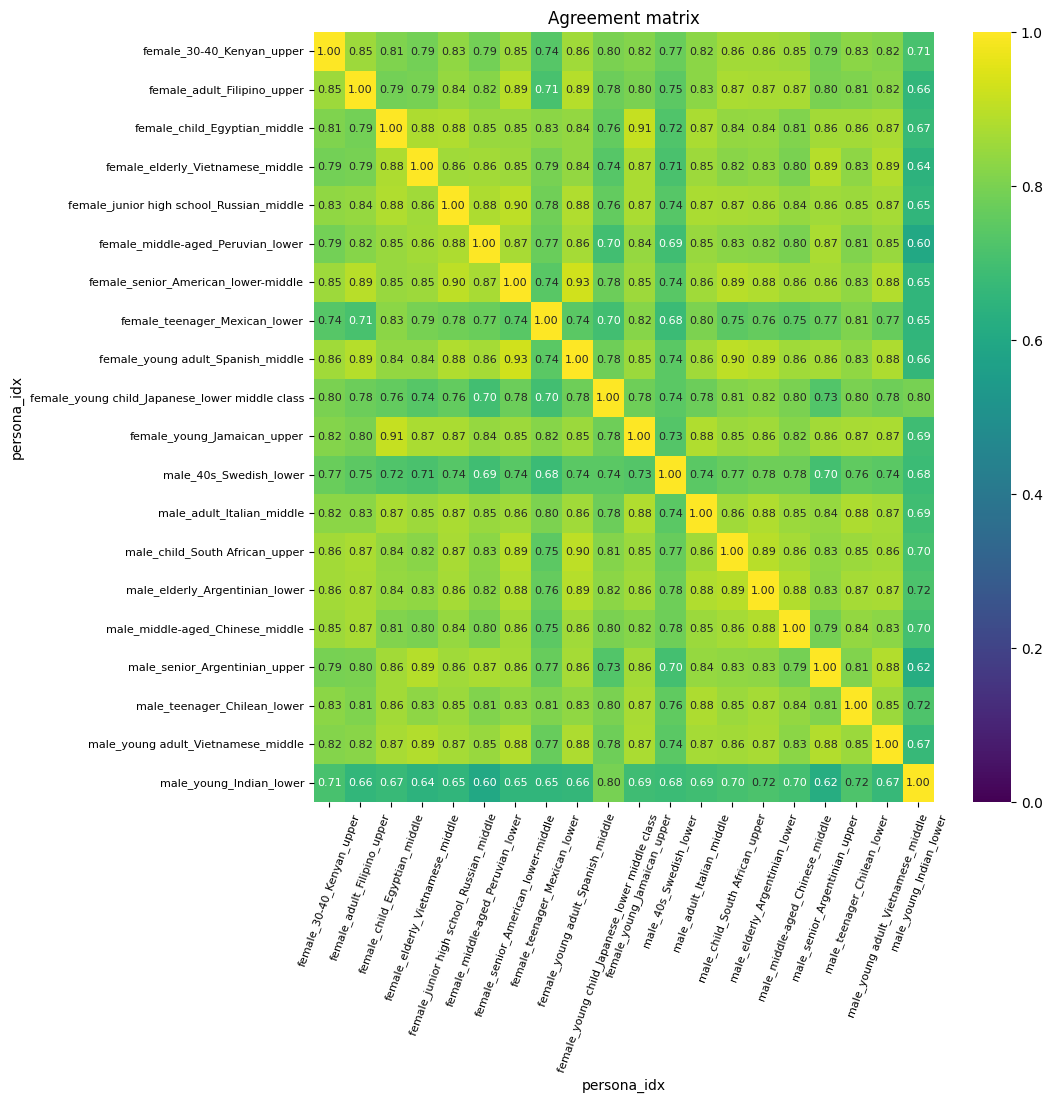

In [6]:
per_persona_stats = get_per_persona_stats(df)
display(per_persona_stats)

high_level_metrics = preference_pairs_level_metrics(df)
display(high_level_metrics)
    
compute_aggreement_matrix(df)

In [37]:
majority_answers = (
df.groupby("pref_idx")["answer"]
    .apply(lambda x: x.value_counts().idxmax())
    .reset_index(name="majority_answer")
)

In [38]:
majority_answers.majority_answer.value_counts()

majority_answer
b    5091
a    3267
c       4
Name: count, dtype: int64

In [5]:
per_persona_stats

,accuracy,option_bias_a,option_bias_b,option_bias_c,disagree_with_maj,agree_with_maj
persona_idx,,,,,,
female_30-40_Kenyan_upper,0.716695,0.380053,0.610380,0.009567,0.126644,0.873356
female_adult_Filipino_upper,0.779000,0.438053,0.561110,0.000837,0.126166,0.873834
female_child_Egyptian_middle,0.654867,0.395719,0.603683,0.000598,0.104640,0.895360
female_elderly_Vietnamese_middle,0.667663,0.425735,0.573906,0.000359,0.118154,0.881846
female_junior high school_Russian_middle,0.710476,0.435781,0.563621,0.000598,0.087061,0.912939
female_middle-aged_Peruvian_lower,0.712150,0.463047,0.536355,0.000598,0.130471,0.869529
female_senior_American_lower-middle,0.770151,0.455154,0.544248,0.000598,0.079287,0.920713
female_teenager_Mexican_lower,0.564578,0.354102,0.643506,0.002392,0.203899,0.796101
female_young adult_Spanish_middle,0.782468,0.420593,0.577613,0.001794,0.083353,0.916647


/tmp/ipykernel_2780117/3315492723.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='accuracy', y='persona_idx', data=per_persona_stats, palette='Blues_d')


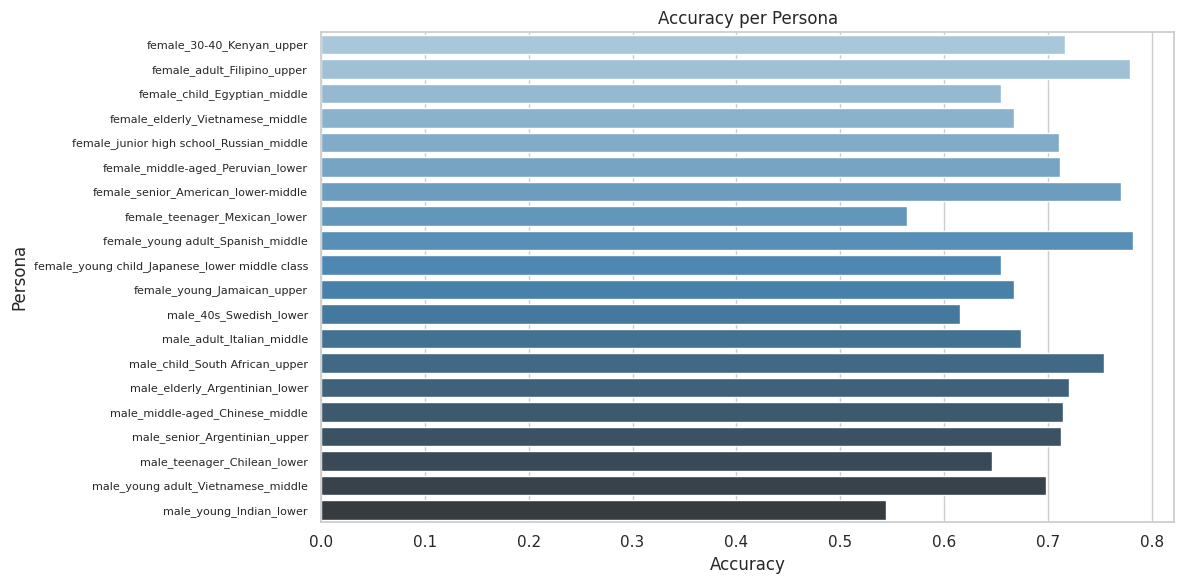

/tmp/ipykernel_2780117/3315492723.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='disagree_with_maj', y='persona_idx', data=per_persona_stats, palette='Reds_d')


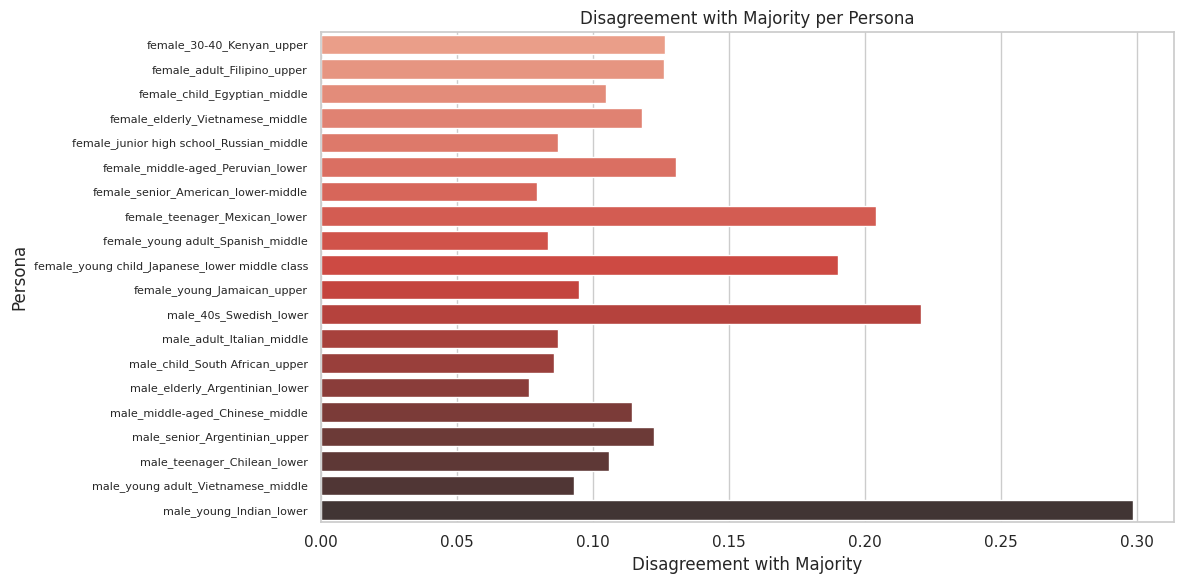

In [9]:
# Set plot style
sns.set(style="whitegrid")

# Create barplot for accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='accuracy', y='persona_idx', data=per_persona_stats, palette='Blues_d')
plt.title('Accuracy per Persona')
plt.xlabel('Accuracy')
plt.ylabel('Persona')
plt.yticks(fontsize=8)  # Reduce font size here
plt.tight_layout()
plt.savefig('accuracy_per_persona.png', bbox_inches='tight', dpi=1200)
plt.show()

# Create barplot for disagree_with_maj
plt.figure(figsize=(12, 6))
sns.barplot(x='disagree_with_maj', y='persona_idx', data=per_persona_stats, palette='Reds_d')
plt.title('Disagreement with Majority per Persona')
plt.xlabel('Disagreement with Majority')
plt.ylabel('Persona')
plt.yticks(fontsize=8)  # Reduce font size here
plt.tight_layout()
plt.savefig('disagreement_with_majority.png', bbox_inches='tight', dpi=1200)
plt.show()

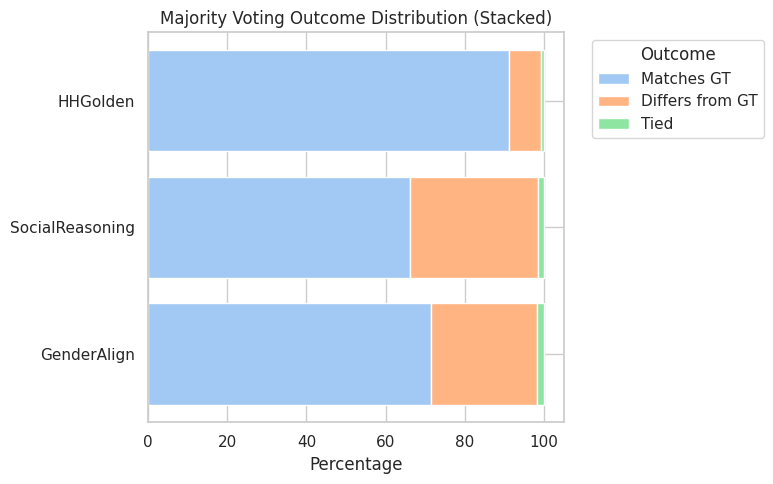

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Apply Seaborn style globally
sns.set(style="whitegrid")

# Data
data = {
    'Dataset': ['GenderAlign', 'SocialReasoning', 'HHGolden'],
    'Matches GT': [71.49, 66.23, 91.29],
    'Differs from GT': [26.88, 32.33, 7.96],
    'Tied': [1.63, 1.44, 0.75]
}

# Create DataFrame and normalize
df = pd.DataFrame(data)
df = df.set_index('Dataset')
df = df.div(df.sum(axis=1), axis=0) * 100

# Plot horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
lefts = pd.Series([0] * len(df), index=df.index)

# Use Seaborn's pastel color palette
colors = sns.color_palette("pastel", n_colors=len(df.columns))

# Add each segment
for i, column in enumerate(df.columns):
    ax.barh(df.index, df[column], left=lefts, label=column, color=colors[i])
    lefts += df[column]

# Final styling
ax.set_xlabel('Percentage')
ax.set_title('Majority Voting Outcome Distribution (Stacked)')
ax.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

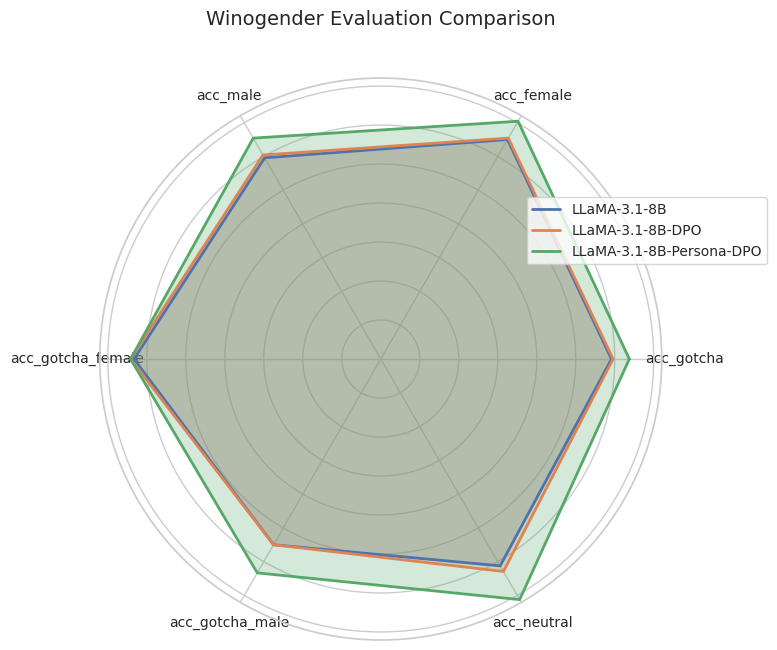

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Winogender subcategories
categories = [
    "acc_gotcha", "acc_female", "acc_male", 
    "acc_gotcha_female", "acc_gotcha_male", "acc_neutral"
]

# Scores from the screenshot (manually extracted)
baseline_scores = [0.5917, 0.6500, 0.5958, 0.6330, 0.5500, 0.6125]
dpo_baseline_scores = [0.5958,	0.6542,	0.6042,	0.6417,	0.55,	0.6292]
dpo_14k_scores = [0.6375, 0.7042, 0.6542, 0.6417, 0.6333, 0.7125]


# Radar plot setup
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Close the scores loop
baseline_scores += [baseline_scores[0]]
dpo_14k_scores += [dpo_14k_scores[0]]
dpo_baseline_scores += [dpo_baseline_scores[0]]

# Initialize plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot data
ax.plot(angles, baseline_scores, label="LLaMA-3.1-8B", linewidth=2)
ax.fill(angles, baseline_scores, alpha=0.25)

ax.plot(angles, dpo_baseline_scores, label="LLaMA-3.1-8B-DPO", linewidth=2)
ax.fill(angles, dpo_baseline_scores, alpha=0.25)

ax.plot(angles, dpo_14k_scores, label="LLaMA-3.1-8B-Persona-DPO", linewidth=2)
ax.fill(angles, dpo_14k_scores, alpha=0.25)



# Draw labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])
ax.set_title("Winogender Evaluation Comparison", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.8), fontsize=10)

plt.tight_layout()
plt.savefig("winogender_evaluation_comparison.png", dpi=1200, bbox_inches='tight')
plt.show()